# K Nearest Neighbours

## 1 Introduction
The second step in any speech recognition task is to use a classifier to classify the test sample based on the features extracted. The K Nearest Neighbour algorithm is one such supervised machine learing algorithm that can be used in classification problems. 

## 2 Required libraries
The required libraries are :
<br>numpy
<br>math
<br>operator

We first import the mentioned libraries, as shown below.

In [1]:
import numpy as np
import math
import operator
import os
import librosa
import random

## 3 Dynamic Time Warping
Dynamic Time Warping is an algorithm used in time-series analysis for measuring similarity between sequences which vary in speed. A well-known application is in automatic speech recognition, to cope with different speaking speeds. 


DTW aims at aligning two sequences of feature vectors by warping the time axis iteratively until an optimal match (according to a suitable metrics) between the two sequences is found. 
<br>Consider two sequences of feature vectors:
<br>A = a1,a2,a3....an
<br>B = b1,b2,b3....bm
The two sequences can be arranged in a grid as follows :
<img src="images/dtw.png">
As it can be seen, both sequences start at the bottom left of the grid. 
Inside each cell a distance measure can be placed, comparing the corresponding elements of the two sequences. Our goal is to find a path through the grid that minimizes the total distance between them. Now for each step, we'll consider the distance between each points in concern and add it with the minimum distance we found so far. This will give us the optimal distance of two sequences up to that position. Hence, our formula will be,

<br>Table[ i ][ j ] := d(i, j) + min(Table[ i-1 ][ j ], Table[ i-1 ][ j-1 ], Table[ i ][ j-1 ])
<br>The overall distance will be the minimum of the sum of the distances between the individual elements. This is represented by the value in the last element of the table.

In [2]:
def dtwDist(x, y, dist, warp=1, w=np.inf, s=1.0):
    assert len(x)
    assert len(y)
    assert np.isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not np.isinf(w):
        D0 = full((r + 1, c + 1), np.inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = np.zeros((r + 1, c + 1))
        D0[0, 1:] = np.inf
        D0[1:, 0] = np.inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (np.isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not np.isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        i, j = np.array(D0.shape) - 2
        p, q = [i], [j]
        while (i > 0) or (j > 0):
            tb = np.argmin((D0[i, j], D0[i, j + 1], D0[i + 1, j]))
            if tb == 0:
                i -= 1
                j -= 1
            elif tb == 1:
                i -= 1
            else:  # (tb == 2):
                j -= 1
            p.insert(0, i)
            q.insert(0, j)
    path=np.array(p), np.array(q)
    
    return D1[-1, -1], C, D1, path
    

Let us now visualize the DTW distance between two sample audio files !

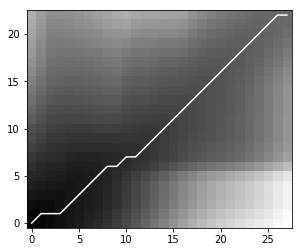

In [3]:
%matplotlib inline
y1,sr1=librosa.load("audio_files/free-spoken-digit-dataset-master/recordings/0_jackson_0.wav")
mfcc2 = librosa.feature.mfcc(y1,sr1,n_mfcc=13)
y2,sr2=librosa.load("audio_files/free-spoken-digit-dataset-master/recordings/0_jackson_1.wav")
mfcc3 = librosa.feature.mfcc(y2,sr2,n_mfcc=13)

dist,cost_matrix,acc_cost_matrix,path=dtwDist(mfcc2.T,mfcc3.T,dist=lambda x, y: np.linalg.norm(x - y, ord=1))

import matplotlib.pyplot as plt

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

## 4 K Nearest Neighbours
Once the DTW distances are computed, the K nearest neighbour algorithm can be used to predict the class of the test data. 
<br> The first step is to compute the neighbours of the test instance. For this, we will be computing the DTW distance of the test instance from each of the train data. The K least distances will be selected and the corresponding neighbours will be computed. 

In [4]:
def getNeighbours(mfcc_train_data,mfcc_test_instance,k,mfcc_train_labels):
    distances=[]
    neighbours=[]
    
    for i in range(len(mfcc_train_data)):
        dist,_,_,_=dtwDist(mfcc_test_instance.T,mfcc_train_data[i].T,dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        distances.append((mfcc_train_labels[i],dist))
    distances.sort(key=operator.itemgetter(1))
    for i in range(k):
        neighbours.append(distances[i][0])
    return neighbours
        

The class response is computed. The class response, in simple terms, computes the number of votes for each class of neighbours. The class with the highest votes represents the class response. 

In [5]:
def ClassResponse(neighbours):
    classvotes={}
    for i in range(len(neighbours)):
        response=neighbours[i][-1]
        if response in classvotes:
            classvotes[response]+=1
        else:
            classvotes[response]=1
    sortedVotes = sorted(classvotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]        

The final step is to determine how accurate your KNN is! The predictions are compared with the results of the test instances and accuracy is computed. Changing the parameter 'K' could change the accuracy in ways dependent on the nature of the data. 

In [6]:
def getAccuracy(test_results,predictions):
    correctPred = 0
    for i in range(len(test_results)):
        if test_results[i] == predictions[i]:
            correctPred += 1
    return round((correctPred/float(len(test_results))) * 100.0, 3)


In [7]:
def knn(mfcc_train_data,mfcc_test_data,k,test_results,mfcc_train_labels):
    predictions=[]
    for i in range(len(mfcc_test_data)):
        neighbours=getNeighbours(mfcc_train_data,mfcc_test_data[i],k,mfcc_train_labels)
        neighbour_pred=ClassResponse(neighbours)
        print('Predicted label =',neighbour_pred,'Actual label =',test_results[i])
        if(neighbour_pred!=test_results[i]):
            print('Wrong prediction !')
        predictions.append(neighbour_pred)
        
    if(test_results!=None):
        accuracy=getAccuracy(test_results,predictions)
        print('Accuracy = ', accuracy, '%')

Let us now test our code for the spoken-digit dataset. It contains around 2000 audio files, 200 each for each digit. 

In [8]:
dirname = "audio_files/free-spoken-digit-dataset-master/recordings"
files = [f for f in os.listdir(dirname)]

We randomly sample 50 audio files of each class. This is done as it would take too much time to test our KNN on the entire dataset. We now test it for a limited number of audio files. 

In [9]:
zero_file=[]
one_file=[]
two_file=[]
three_file=[]
four_file=[]
five_file=[]
six_file=[]
seven_file=[]
eight_file=[]
nine_file=[]
for i in range(len(files)):
    if(files[i][0]=='0'):
        zero_file.append(files[i])
    if(files[i][0]=='1'):
        one_file.append(files[i])
    if(files[i][0]=='2'):
        two_file.append(files[i])
    if(files[i][0]=='3'):
        three_file.append(files[i])
    if(files[i][0]=='4'):
        four_file.append(files[i])
    if(files[i][0]=='5'):
        five_file.append(files[i])
    if(files[i][0]=='6'):
        six_file.append(files[i])
    if(files[i][0]=='7'):
        seven_file.append(files[i])
    if(files[i][0]=='8'):
        eight_file.append(files[i])
    if(files[i][0]=='9'):
        nine_file.append(files[i])
files_sampled=random.sample(zero_file, 50)+random.sample(one_file, 50)+random.sample(two_file, 50)+random.sample(three_file, 50)+random.sample(four_file, 50)+random.sample(five_file, 50)+random.sample(six_file, 50)+random.sample(seven_file, 50)+random.sample(eight_file, 50)+random.sample(nine_file, 50)

MFCC is extracted for all the audio files. The class labels are also extracted in the y_labels list. 

In [10]:
mfcc_list=[]
y_labels=[]
for i in range(len(files_sampled)):
    y, sr = librosa.load(dirname+"/"+files[i])
    mfcc1 = librosa.feature.mfcc(y,sr,n_mfcc=13)
    mfcc_list.append(mfcc1)
    y_labels.append(files[i][0])
    

The data is split into train and test with the ratio 0.2

In [11]:
from sklearn.model_selection import train_test_split
mfcc_train,mfcc_test,y_train,y_test=train_test_split(mfcc_list,y_labels,test_size=0.2)

In [12]:
knn(mfcc_train,mfcc_test,5,y_test,y_train)

Predicted label = 5 Actual label = 5
Predicted label = 8 Actual label = 8
Predicted label = 3 Actual label = 7
Wrong prediction !
Predicted label = 7 Actual label = 7
Predicted label = 0 Actual label = 0
Predicted label = 5 Actual label = 5
Predicted label = 3 Actual label = 3
Predicted label = 0 Actual label = 0
Predicted label = 0 Actual label = 0
Predicted label = 9 Actual label = 9
Predicted label = 5 Actual label = 5
Predicted label = 8 Actual label = 8
Predicted label = 4 Actual label = 4
Predicted label = 7 Actual label = 7
Predicted label = 8 Actual label = 8
Predicted label = 9 Actual label = 9
Predicted label = 2 Actual label = 2
Predicted label = 8 Actual label = 8
Predicted label = 2 Actual label = 2
Predicted label = 2 Actual label = 2
Predicted label = 6 Actual label = 6
Predicted label = 7 Actual label = 7
Predicted label = 5 Actual label = 5
Predicted label = 3 Actual label = 3
Predicted label = 0 Actual label = 0
Predicted label = 6 Actual label = 6
Predicted label = 4

In [13]:
y1,sr1=librosa.load("audio_files/Kshama.wav")
mfcc2 = librosa.feature.mfcc(y1,sr1,n_mfcc=13)
knn(mfcc_list,[mfcc2],5,['1'],y_labels)

Predicted label = 1 Actual label = 1
Accuracy =  100.0 %
